In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import brentq
import numpy as np

import sys
sys.path.append('../experimental')
import substrings
import clash_analysis

# Main goal: Figure out whether there it is possible to be able to point to some level and know that probability of failure going there is about 0.  (Started February 20 2017)

### Question 1: How does the theoretical probability of a string matching with a prefix compare to the observed ratio?

Here the theoretical probability is $1 - (1 - \lambda^k)^{n - k}$ where $\lambda$ is the probability of a two distinct indices in the generalized string having a shared letter, $n$ is the size of the string, and $k$ is the size of the matching substring.

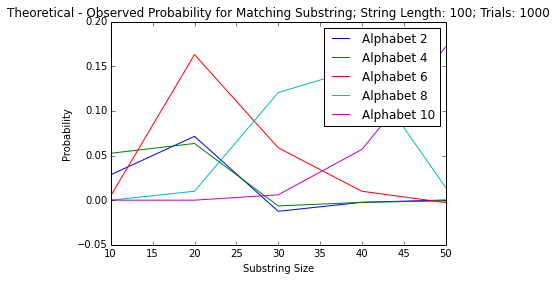

In [3]:
# Constants
TRIALS = 1000
STRING_LENGTH = 100
ALPH_SIZES = [2, 4, 6, 8, 10]
SUB_LENS = [10, 20, 30, 40, 50]
# Get the differences between the theoretical and observed
data_by_alph = [[] for _ in range(len(ALPH_SIZES))]
for alph_index, alph_size in enumerate(ALPH_SIZES):
    for sub_len in SUB_LENS:
        found_values = substrings.test_substring_length_prob(sub_len, alph_size, STRING_LENGTH, TRIALS)
        data_by_alph[alph_index].append((found_values[0] - found_values[1]))
# Plot all the found values
for alph_index, alph_size in enumerate(ALPH_SIZES):
    plt.plot(SUB_LENS, data_by_alph[alph_index], label=('Alphabet ' + str(alph_size)))
plt.legend(loc='upper right')
plt.title('Theoretical - Observed Probability for Matching Substring'
          + '; String Length: ' + str(STRING_LENGTH)
          + '; Trials: ' + str(TRIALS))
plt.xlabel('Substring Size')
plt.ylabel('Probability')
plt.show()

### Question 2: How does our theoretical probability decay as the length of matching substrings gets bigger? i.e. Given theoretical probaability of there existing some substring that matches with a prefix of the generalized string, is there a clear point at which this probability is about zero? What about for different alphabets.

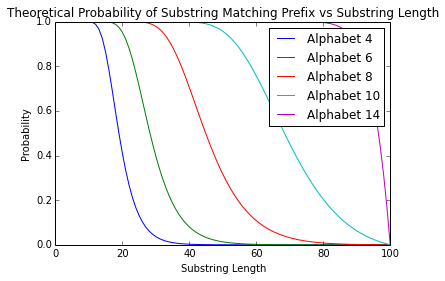

In [19]:
STRING_LENGTH = 100
ALPH_SIZES = [4, 6, 8, 10, 14]
# Assemble the datapoints for each alphabet size.
probs = [[] for _ in range(len(ALPH_SIZES))]
for alph_index, alph_size in enumerate(ALPH_SIZES):
    for sub_len in range(STRING_LENGTH + 1):
        probs[alph_index].append(substrings.get_theoretical_substring_prob(sub_len, alph_size, STRING_LENGTH))
# Plot the computed datapoints.
for alph_index, alph_size in enumerate(ALPH_SIZES):
    plt.plot(range(STRING_LENGTH + 1), probs[alph_index], label=('Alphabet ' + str(alph_size)))
plt.legend(loc='upper right')
plt.title('Theoretical Probability of Substring Matching Prefix vs Substring Length')
plt.xlabel('Substring Length')
plt.ylabel('Probability')
plt.show()

## Question 3: Can we approximate at what substring length we jump from high probability to low probability?

Let $f(k;\lambda, n)$ be the pdf for there being a substring matching the prefix of length $k$ (i.e. what is shown above). It seems the value where the probability jumps from 1 to 0 can be found via the inflection point. Therefore we want to find where $\frac{\partial^2}{\partial k^2} f(k;\lambda, n) = 0$

In [2]:
# Return second derivative for the pdf.
def get_second_deriv(alph, n):
    # Second derivative of function computed via wolfram alpha:
    # http://www.wolframalpha.com/input/?i=second+derivative+of+-(1-a%5Ex)%5E(b-x)
    def second_deriv(k):
        # Compute common expressions once to save work.
        lam = 1 - substrings.get_theoretical_ratio_disjoint(alph)
        log_lam = np.log(lam)
        one_minus_lam_k = 1 - lam ** k
        
        to_return = 0
        to_return -= (lam ** k) * (log_lam ** 2) * (n - k) / (one_minus_lam_k)
        to_return += 2 * (lam ** k) * log_lam / one_minus_lam_k
        to_return -= (lam ** (2 * k)) * (np.log(k) ** 2) * (n - k) / (one_minus_lam_k ** k)
        to_return *= -1 * one_minus_lam_k ** (n - k)
        to_return -= (-1 * lam ** k * log_lam * (n - k) / (one_minus_lam_k) - np.log(one_minus_lam_k)) ** 2
        to_return *= one_minus_lam_k ** (n - k)
        return to_return
    return second_deriv

17.5686769853


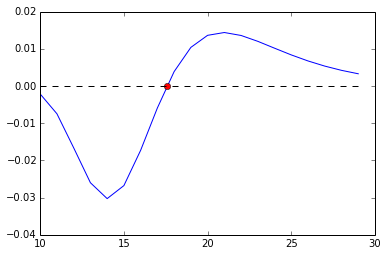

In [86]:
# See if we can find the inflection point with the second derivative.
# Constants
ALPHABET = 4
STRING_LENGTH = 100

# Use root finding to find the inflection point.
deriv2 = get_second_deriv(ALPHABET, STRING_LENGTH)
xs = range(10, 30)
deriv2s = [deriv2(x) for x in xs]
inflection = brentq(deriv2, 15, 20)
plt.plot(xs, deriv2s, 'b-', [inflection], [deriv(inflection)], 'ro', xs, [0 for _ in xs], 'k--')

print(inflection)

### Question 4: How well does this do at predicting when the average level size levels off?

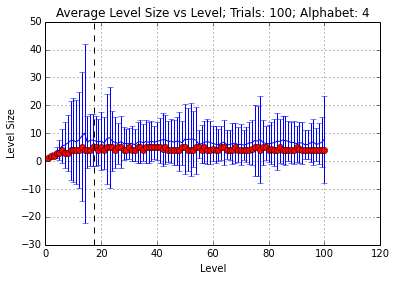

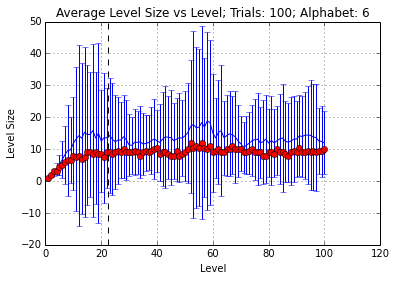

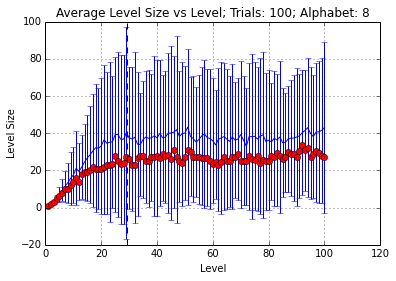

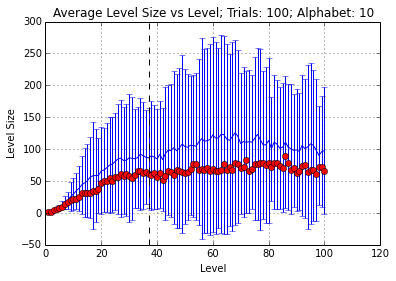

In [5]:
# Constants
STRING_LENGTH = 100
ALPH_SIZES = [4, 6, 8, 10]
NUM_TRIALS = 100

# Plot for every alphabet size.
for alph_size in ALPH_SIZES:
    # Find the inflection point.
    deriv2 = get_second_deriv(alph_size, STRING_LENGTH)
    inflection = brentq(deriv2, 15, 50)
    # Plot the average level trend along with the inflection.
    alph = clash_analysis.create_alphabet(alph_size)
    clash_analysis.plot_lvlsize_trend(NUM_TRIALS, STRING_LENGTH, alph, inflection)

This seems to do a decent job of predicting where the average levels off; however, there is a lot of variation so it is hard to tell how accurate it is. Furthermore, the last trial with alphabet size of 10 is pretty off but this is as expected since the change from high to low probability is much more gradual when the alphabet size is higher.

### Question 5: How does the value of the inflection point change as a function of string length and alphabet size?

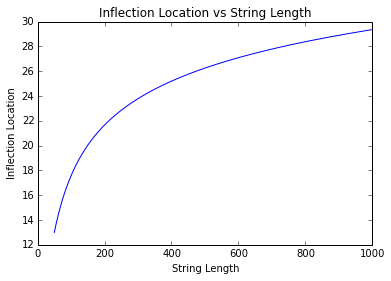

In [13]:
# ANALYSIS FOR STRING LENGTH VARIATION
# Constants
LOWER_BOUND = 50
UPPER_BOUND = 1000
STEP_SIZE = 1
ALPH_SIZE = 4

# Collect inflection point data.
inflections = []
string_lengths = range(LOWER_BOUND, UPPER_BOUND, STEP_SIZE)
for str_len in string_lengths:
    deriv = get_second_deriv(ALPH_SIZE, str_len)
    inflections.append(brentq(deriv, 10, str_len))

# Plot inflections
plt.plot(string_lengths, inflections)
plt.xlabel('String Length')
plt.ylabel('Inflection Location')
plt.title('Inflection Location vs String Length')

From inspection it seems that, the location of the inspection point grows as $\mathcal{O}(log(n))$

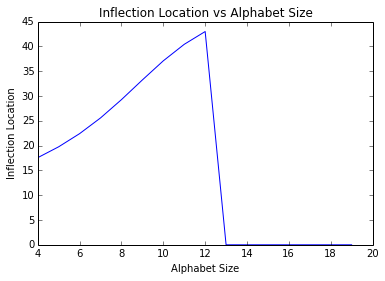

In [16]:
# ANALYSIS FOR ALPHABET SIZE VARIATION
# Constants
LOWER_BOUND = 4
UPPER_BOUND = 20
STEP_SIZE = 1
STRING_LENGTH = 100

# Collect inflection point data.
inflections = []
alph_sizes = range(LOWER_BOUND, UPPER_BOUND, STEP_SIZE)
for alph_size in alph_sizes:
    deriv = get_second_deriv(alph_size, STRING_LENGTH)
    try:
        inflections.append(brentq(deriv, 10, STRING_LENGTH))
    except:
        inflections.append(0)

# Plot inflections
plt.plot(alph_sizes, inflections)
plt.xlabel('Alphabet Size')
plt.ylabel('Inflection Location')
plt.title('Inflection Location vs Alphabet Size')

It is hard to tell exactly what the inflection point grows as with respect to alphabet size because after a certain point there is no inflection point. 